In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends import backend_pdf
from scipy.optimize import curve_fit
import scipy.stats as st
from scipy.odr import ODR, Model, Data, RealData

## Configuration

In [75]:
# list of PMTs at 0 voltage form HV files + disconnected pmts: 290
offPMTs = [1, 111, 143, 166, 192, 230, 238, 254, 222, 302, 309, 340, 353, 290 ]
offChs = PMTid_to_channel(offPMTs)

WESTonly = [ x for x in range(1,181) ]
chWESTonly = PMTid_to_channel(WESTonly)

EASTonly = [ x for x in range(181,361) ]
chEASTonly = PMTid_to_channel(EASTonly)

# drifting PMTs --> wait for full list
driftPMTsEAST = [ 282, 288, 296, 307, 310, 319, 346, 350]
driftPMTsWEST = [ 59, 63, 81, 93, 95, 142, 148, 169, 170, 179 ]
driftChsEAST = PMTid_to_channel(driftPMTsEAST)
driftChsWEST = PMTid_to_channel(driftPMTsWEST)

# PMTs not changed
nochangePMTs = [310, 282, 262, 248, 90]
nochangeChs = PMTid_to_channel(nochangePMTs)
print(offChs)

[350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71]


In [21]:
def getDataframe(file, offPMTs):
       
    df=pd.read_csv(file, sep=',')
    
    # remove list of PMTs that are off
    channel_ids = PMTid_to_channel(offPMTs)
    df= df[~df['pmt'].isin(channel_ids)]
    
    return df

In [81]:
# The fit function
def gaus(x,a,mean,sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

def fitGaussian(x, BINSIZE=0.1, RMIN=0.0, RMAX=10.0, p0=(5., 0.5)):
    
    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(x,bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    eparam = np.diag(pcov)**0.5
    
    return xs, ys, param, eparam

In [92]:
srcpath = "/icarus/data/users/mvicenzi/pmt-calibration/amplitudedb/"
figpath = "/icarus/data/users/mvicenzi/pmt-calibration/figs/"

# amplitude
afile = srcpath + "bkgphamplitude_run10333_1692369304.csv" #+30V
#afile = srcpath + "bkgphamplitude_run10313_1692203499.csv"
#afile = srcpath + "bkgphamplitude_run10334_1692373315.csv" #-30V
#afile = srcpath + "bkgphamplitude_run10335_1692377987.csv" #-50V
#afile = srcpath + "bkgphamplitude_run10336_1692382296.csv" #-100V

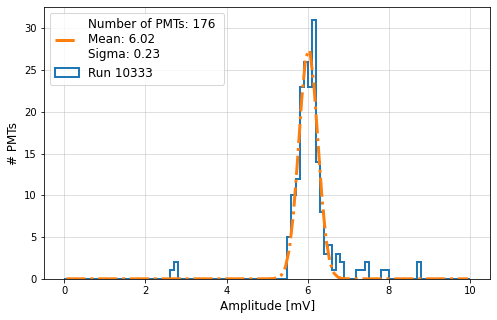

In [93]:
run=getRun(afile)
adata = getDataFrame(afile, offPMTs)
xs, ys, param, eparam = fitGaussian(adata["q"].to_numpy())
ys_fitted = gaus(xs, *param)

fig = plt.figure()
plt.hist( adata["q"], histtype="step", lw=2, range=(0,10), bins=100, label="Run {}".format(run))

plt.plot( xs, ys_fitted, '-.', lw=3.0, label="Number of PMTs: {:d} \nMean: {:.2f} \nSigma: {:.2f}".format( np.sum(ys), param[1], param[2]))

plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.xlabel("Amplitude [mV]",fontsize=12)
plt.ylabel("# PMTs",fontsize=12)
plt.show()

## Amplitude vs gain

In [161]:
def getAmplitudes( srcpath, filelist, offPMTs, start_values ):
    
    means = []
    sigmas = []
    for i, file in enumerate(filelist):
        
        f = srcpath + file
        run=getRun(f)
        adata = getDataFrame(f, offPMTs)
        
        xs, ys, param, eparam = fitGaussian(adata["q"].to_numpy(),p0=(start_values[i], 0.5))
        means.append(param[1])
        sigmas.append(param[2])
    
    return means, sigmas

def getGains( srcpath, filelist, offPMTs, start_values ):
    
    means = []
    sigmas = []
    for i, file in enumerate(filelist):
        
        f = srcpath + file
        run=getRun(f)
        adata = getDataFrame(f, offPMTs)
        
        xs, ys, param, eparam = fitGaussian(adata["q"].to_numpy(),BINSIZE=0.005,RMIN=0.0,RMAX=1.0,p0=(start_values[i], 0.05))
        means.append(param[1])
        sigmas.append(param[2])
    
    return means, sigmas

def line( p, x ):
    a, b = p
    return a*x+b

def getallForSingle( gain_file, amp_file , offPMTs, starts ):
    
    adata = getDataFrame(amp_file, offPMTs)
    gdata = getDataFrame(gain_file, offPMTs)
    
    xs, ys, param, eparam = fitGaussian(adata["q"].to_numpy(),p0=(starts[0], 0.5))
    amp, asigma = param[1], param[2]
    xs, ys, param, eparam = fitGaussian(gdata["q"].to_numpy(),BINSIZE=0.005,RMIN=0.0,RMAX=1.0,p0=(starts[1], 0.05))
    gain, gsigma = param[1], param[2]
    
    return gain, gsigma, amp, asigma

In [183]:
voltages = [ "+30V", "Nominal", "-30V", "-50V", "-100V"]

In [144]:
srcpath = "/icarus/data/users/mvicenzi/pmt-calibration/amplitudedb/"
filelist = ["bkgphamplitude_run10333_1692369304.csv", #+30V
            "bkgphamplitude_run10313_1692203499.csv",
            "bkgphamplitude_run10334_1692373315.csv", #-30V
            "bkgphamplitude_run10335_1692377987.csv", #-50V
            "bkgphamplitude_run10336_1692382296.csv", #-100V
           ]
start_values = [ 6.0, 5.0, 4.0, 4.0, 3.0]
amplitudes, asigmas = getAmplitudes(srcpath, filelist, offPMTs, start_values)

In [145]:
print(amplitudes, asigmas)

[6.015954176250274, 5.316637803959696, 4.661153191375341, 4.282462804886502, 3.4366479972165123] [0.23107041876389284, 0.2494356178314887, 0.28489888359866383, 0.31190693231886146, 0.36816964499186217]


In [146]:
dbpath = "/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/"
files = [ "equalization_run10333_1692368269.csv", #+30V
          "equalization_run10313_1692203859.csv", #nominal 
          "equalization_run10334_1692374665.csv", #-30V
          "equalization_run10335_1692377717.csv", #-50V
          "equalization_run10336_1692384276.csv", #-100V
        ]
start_values = [0.6, 0.55, 0.48, 0.45, 0.38]
#exclude east + off
exclude = offPMTs + EASTonly
gains, gsigmas = getGains( dbpath, files, exclude, start_values )

In [147]:
print( gains, gsigmas)

[0.613620115803575, 0.5456133485294654, 0.48503285640566657, 0.4492444162965812, 0.37586118916972866] [0.02212665097130843, 0.011027419131083415, 0.008463822670886688, 0.010404174658829602, 0.014520028838122206]


In [165]:
gainpath = "/icarus/data/users/mvicenzi/pmt-calibration/calibrationdb/backgroundphotons_run9342_1672496767.csv"
amppath = "/icarus/data/users/mvicenzi/pmt-calibration/amplitudedb/bkgphamplitude_run9342_1672496767.csv"
starts = [3.5, 0.45]

g, sg, a, sa = getallForSingle( gainpath, amppath , offPMTs, starts )
print(g, sg, a, sa)

0.4468082573978873 0.006358063937344117 3.4262978505864994 0.13148517107524574


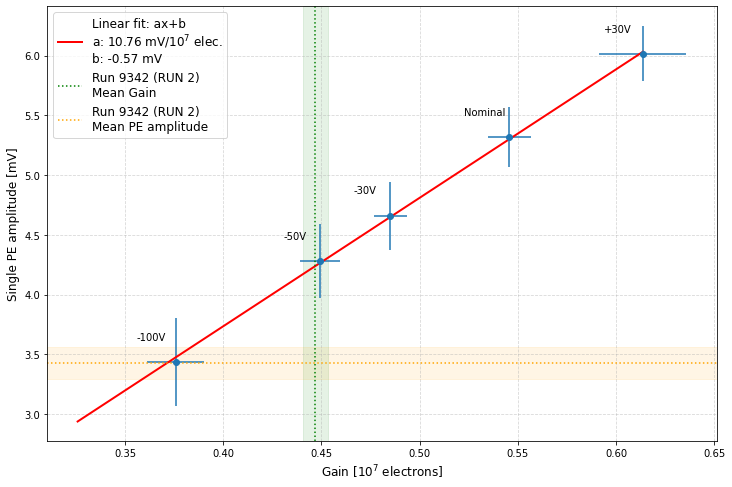

In [189]:
fig = plt.figure(figsize=(12,8))
plt.errorbar(x=gains, y=amplitudes, xerr=gsigmas, yerr=asigmas, fmt="o")

data = RealData(x=gains, y=amplitudes, sx=gsigmas, sy=asigmas)
model = Model(line)
odr = ODR(data, model, beta0=[1,1])
odr.set_job(fit_type=2)
output = odr.run()

xn = np.linspace(np.min(gains)-0.05,np.max(gains),200)
yn = line(output.beta, xn)
param = output.beta
plt.plot(xn,yn,color="red",lw=2, label="Linear fit: ax+b\na: {:.2f} mV/10$^7$ elec.\nb: {:.2f} mV".format(param[0],param[1]))

plt.axvline(x=g,linestyle="dotted",label="Run 9342 (RUN 2)\nMean Gain", color="green")
plt.axvspan(xmin=g-sg,xmax=g+sg,color="green",alpha=0.1)

plt.axhline(y=a,linestyle="dotted",label="Run 9342 (RUN 2)\nMean PE amplitude", color="orange")
plt.axhspan(ymin=a-sa,ymax=a+sa,color="orange",alpha=0.1)

for i,v in enumerate(voltages):
    plt.annotate( v, xy=(gains[i],amplitudes[i]),textcoords="offset points", xytext=(-25,22), ha='center')

plt.grid(alpha=0.5,linestyle="dashed")
plt.xlabel("Gain [10$^7$ electrons]", fontsize=12)
plt.ylabel("Single PE amplitude [mV]", fontsize=12)
plt.legend(fontsize=12)

plt.savefig("figs/WEST_AmplitudeVsGain.png", dpi=100)
plt.show()